Import and download dataset

In [41]:
# encoder
# decoder
# optimizer
# loss objective
import itertools, numpy as np
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader 
from torch.distributions import normal
import torch.optim as optim
device='cuda:0'

print('starting')

# Create encoder - q(z|x) and decoder - p(x|z) networks
# Create the network

encoder = nn.Sequential(
          nn.Linear(28*28,128),
          nn.ReLU(),
          nn.Linear(128,4)
        ).to(device)
# [mu_1, mu_2, sigma_1, sigma_2]

decoder = nn.Sequential(
          nn.Linear(2,128),
          nn.ReLU(),
          nn.Linear(128,28*28),
          nn.Sigmoid()
        ).to(device)

# [mu_1, mu_2, ....., sigma_1, sigma_2, ....]
params = itertools.chain(encoder.parameters(), decoder.parameters())
optimizer = optim.Adam(params, lr=1e-4)

# Create objective function

batch_size = 100
train_data = torchvision.datasets.MNIST('datasets/mnist', train=True, transform=torchvision.transforms.ToTensor(), target_transform=None, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=10)
epochs = 50
alpha = 0.01
beta = 1
eps_dist = normal.Normal(torch.zeros((batch_size,2)), torch.ones((batch_size,2)))
lossFn = nn.BCELoss()

for e in range(epochs):
    l1_epoch, l2_epoch, c = 0, 0, 0
    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.view(batch_size, -1).to(device)
        enc = encoder(x)
        mu, log_sigma = enc[:,:2], enc[:,2:]
        eps = eps_dist.sample().to(device)
        z = mu+eps*torch.exp(log_sigma)
        dec = decoder(z)
#         mu_dec, log_sigma_dec = dec[:,:28*28], dec[:,28*28:]
#         dist = normal.Normal(mu_dec, torch.exp(log_sigma_dec)+1e-10)

        l1 = -0.5*(1+2*log_sigma-mu**2-torch.exp(log_sigma)**2).sum(axis=-1).mean()
#         l2 = -dist.log_prob(x).sum(axis=-1).mean()
        l2 = lossFn(dec, x)
        loss = alpha*l1+beta*l2
        loss.backward()
        optimizer.step()
        l1_epoch+=l1.data.cpu().numpy()
        l2_epoch+=l2.data.cpu().numpy()
        c+=1
    print('Epoch {}, KL Loss {}, Reconstruction loss {}'.format(e+1, round(l1_epoch/c,10), round(l2_epoch/c,10)))
        

starting
Epoch 1, KL Loss 4.1256485497, Reconstruction loss 0.375404441
Epoch 2, KL Loss 2.8860034156, Reconstruction loss 0.2762624161
Epoch 3, KL Loss 2.31196055, Reconstruction loss 0.2584188727
Epoch 4, KL Loss 1.9994074617, Reconstruction loss 0.2487947283
Epoch 5, KL Loss 1.7667478436, Reconstruction loss 0.2437157936
Epoch 6, KL Loss 1.566921729, Reconstruction loss 0.2401757642
Epoch 7, KL Loss 1.4763834921, Reconstruction loss 0.2368485164
Epoch 8, KL Loss 1.4912363494, Reconstruction loss 0.233870629
Epoch 9, KL Loss 1.5517650582, Reconstruction loss 0.2316137137
Epoch 10, KL Loss 1.6075884285, Reconstruction loss 0.2297159789
Epoch 11, KL Loss 1.6614775807, Reconstruction loss 0.2282797864
Epoch 12, KL Loss 1.7072579799, Reconstruction loss 0.2268912229
Epoch 13, KL Loss 1.7572052121, Reconstruction loss 0.2256615146
Epoch 14, KL Loss 1.8047098837, Reconstruction loss 0.2245676994
Epoch 15, KL Loss 1.8478281438, Reconstruction loss 0.2235213642
Epoch 16, KL Loss 1.8899867763

In [ ]:
# visualize 100 random samples
imshow(torchvision.utils.make_grid(images))

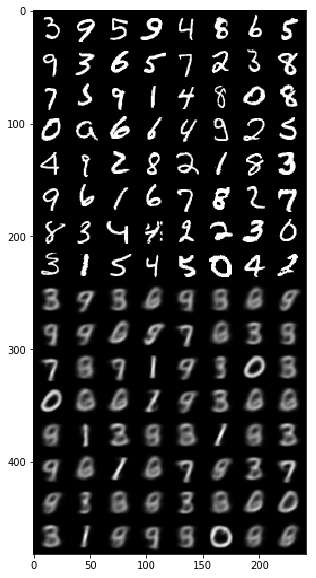

In [42]:
test_batch_size = 64
test_data = torchvision.datasets.MNIST('datasets/mnist', transform = torchvision.transforms.ToTensor(), train=False, download=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=test_batch_size)
test_iter = iter(test_loader)

import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    x, y = test_iter.next()
    x = x.view(test_batch_size, -1).to(device)
    enc = encoder(x)
    mu, sigma = enc[:,:2], enc[:,2:]
    dec = decoder(mu)
    vec = torch.cat((x, dec), dim=0)
    grid_img = torchvision.utils.make_grid(vec.view(-1,1,28,28), nrow=8).permute(1,2,0)
    plt.figure(figsize=(20,10))
    plt.imshow(grid_img.cpu().numpy())


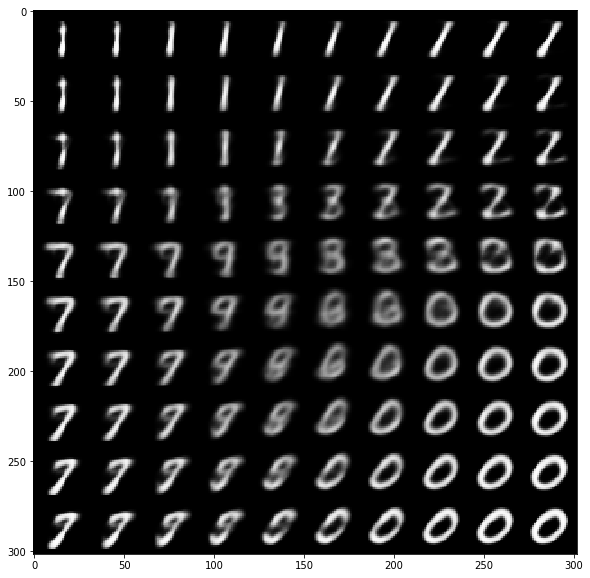

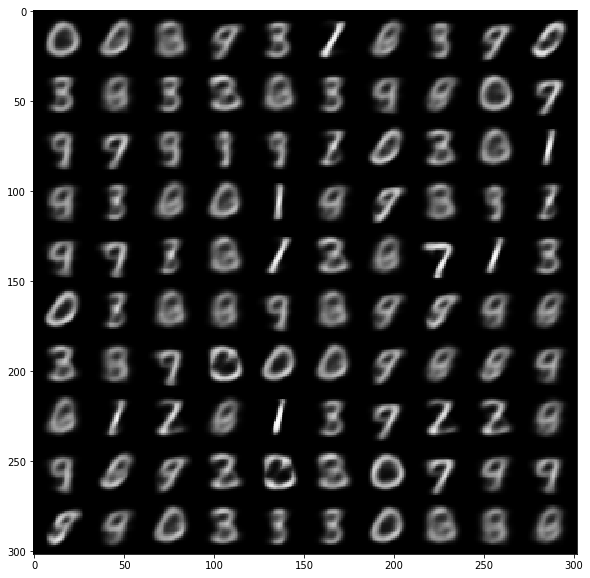

In [43]:
# Reconstruction of latent space
z = np.meshgrid(np.linspace(-3,3,10), np.linspace(-3,3,10))
zx, zy = z[0].reshape(-1,1), z[1].reshape(-1,1)
z = np.concatenate((zx,zy), axis=1)

with torch.no_grad():
    dec = decoder(torch.tensor(z, dtype=torch.float).to(device))
    mu_dec, sigma_dec = dec[:,:28*28], dec[:,28*28:]
    grid_img = torchvision.utils.make_grid(mu_dec.view(-1,1,28,28), nrow=10).permute(1,2,0)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.cpu().numpy())
    
    
# Generating random characters
z = np.random.normal(loc = [0,0], scale=[1,1], size=(100,2))
# print(z)
with torch.no_grad():
    dec = decoder(torch.tensor(z, dtype=torch.float).to(device))
    mu_dec, sigma_dec = dec[:,:28*28], dec[:,28*28:]
    grid_img = torchvision.utils.make_grid(mu_dec.view(-1,1,28,28), nrow=10).permute(1,2,0)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.cpu().numpy())


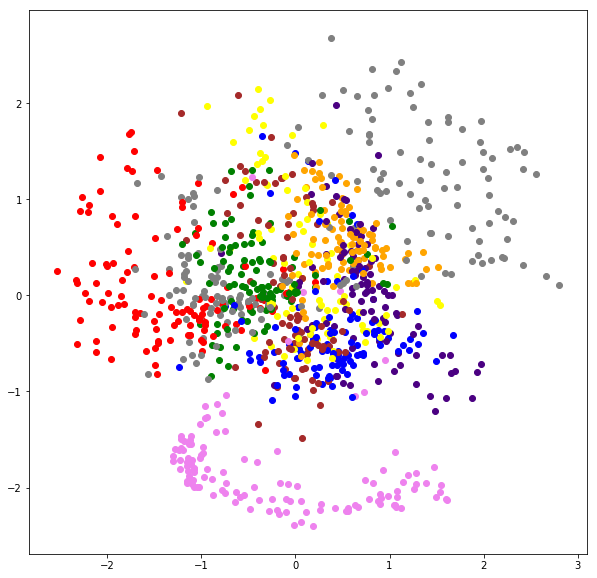

In [44]:
test_batch_size = 1000
test_data = torchvision.datasets.MNIST('datasets/mnist', transform = torchvision.transforms.ToTensor(), train=False, download=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=test_batch_size)
test_iter = iter(test_loader)
from matplotlib import colors
with torch.no_grad():
    x, y = test_iter.next()
    x = x.view(test_batch_size, -1).to(device)
    enc = encoder(x)
    mu, sigma = enc[:,:2], enc[:,2:]
    dec = decoder(mu)
    mu, sigma = mu.cpu().numpy(), sigma.cpu().numpy()
    mu_dec, sigma_dec = dec[:,:28*28], dec[:,28*28:]
    cmap = ['grey', 'violet', 'indigo', 'blue','green', 'yellow', 'orange', 'red', 'brown', 'black']
    plt.figure(figsize=(10,10))
    for i, pt in enumerate(mu):
        plt.scatter(pt[0], pt[1], color=cmap[y[i]%9])
#     plt.show()
#     for i, pt in enumerate(sigma):
#         plt.scatter(pt[0], pt[1], color=cmap[y[i]])
#     plt.show()
# m = normal.Normal(torch.FloatTensor([0,1]), torch.FloatTensor([0.1,0.1]))
# s = m.log_prob(torch.FloatTensor([0,1]))
# print(s)

In [ ]:
import numpy as np
import torch

torch.softmax(torch.FloatTensor([[1,2,3]]), dim=-1)

In [35]:
help(np.random.normal)

Help on built-in function normal:

normal(...) method of numpy.random.mtrand.RandomState instance
    normal(loc=0.0, scale=1.0, size=None)
    
    Draw random samples from a normal (Gaussian) distribution.
    
    The probability density function of the normal distribution, first
    derived by De Moivre and 200 years later by both Gauss and Laplace
    independently [2]_, is often called the bell curve because of
    its characteristic shape (see the example below).
    
    The normal distributions occurs often in nature.  For example, it
    describes the commonly occurring distribution of samples influenced
    by a large number of tiny, random disturbances, each with its own
    unique distribution [2]_.
    
    .. note::
        New code should use the ``normal`` method of a ``default_rng()``
        instance instead; see `random-quick-start`.
    
    Parameters
    ----------
    loc : float or array_like of floats
        Mean ("centre") of the distribution.
    scale : fl